**Hopefully, you arrived here from [`participant_filtering.ipynb`](participant_filtering.ipynb). If not, make sure to run through that code first!**

This notebook serves as the main post-processing operation for our **Street-Sim-V2** project. Here, we look at each participants' EEG data. **Note that P1, P3, and P5 are the only participants whose EEG is suitable for EEG analysis. P2, P4, and P6 feature too many issues with disjointed EEG readings. All participants' gaze data is valid, however.**

# 0. Imports, Constants

Simply import all necessary python packages + initialize our frequency bands and electrodes.

You'll notice at the end that we have a bunch of dictionary mappers. This is to analyze our gaze data targets into ones that, frankly, make more sense in terms of categorization.

In [1]:
### ====================== ###
### Python packages
### ====================== ###

# Public packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
from sklearn import preprocessing
from IPython.display import display as iDisplay, Markdown, Latex
import seaborn as sns
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
pd.options.mode.chained_assignment = None  # default='warn'

# Custom Helpers
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds
le = preprocessing.LabelEncoder()

### ====================== ###
### Modifiable Variables
### ====================== ###

# Frequency Bands, Electrodes, Gaze Thresholds, directory to the user data for this report, and which participants to look at.
_FREQUENCY_BANDS = ['Delta','Theta','Alpha','Beta','Gamma']
_ELECTRODES = ['AF7','AF8']
_FREQUENCY_COLORS = ['purple','red', 'blue', 'green', 'orange']
_GAZE_THRESHOLD = 250.0
_DATA_DIR = './data/'
_PARTICIPANTS = ['P1','P2','P3','P4','P5','P6']
_PARTICIPANTS_DIRS_CORRELATIONS = ['P1','P3','P5']
_PARTICIPANTS_DIRS_GAZES = ['P1','P2','P3','P4','P5','P6']

### ====================== ###
### Auto-Generated Variables
### ====================== ###

# Generate freq-band combination column names
freq_band_colnames = []
for freq in _FREQUENCY_BANDS: 
    for electrode in _ELECTRODES:
        freq_band_colnames.append(f'{freq}_{electrode}')

# Generate an output directory.
_OUTPUT_DIR = os.path.join(_DATA_DIR, f'outputs_correlations_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/')
try: os.makedirs(_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

### ====================== ###
### Global, Constant Variables
### ====================== ###

# Lists of objects in the scene
_STATIC_OBJECTS = [
    'NorthSidewalk', 'SouthSidewalk',
    'NorthWalkingPole', 'NorthDiagonalPole', 'NorthWalkingSignal', 'NorthCarSignal',
    'SouthWalkingPole', 'SouthDiagonalPole', 'SouthWalkingSignal', 'SouthCarSignal',
    'RoadEast', 'RoadWest', 'RoadCrosswalk',
    'NE_Tree_10', 'NE_Tree_30', 'NE_Tree_50',
    'NW_Tree_10', 'NW_Tree_30', 'NW_Tree_50',
    'SE_Tree_10', 'SE_Tree_30', 'SE_Tree_50',
    'SW_Tree_10', 'SW_Tree_30', 'SW_Tree_50']
_DYNAMIC_OBJECTS = [
    'Car1-Detailed', 'Car2-Detailed', 'Car3-Detailed', 'Car4-Detailed', 'Car5-Detailed',
    'Sedan1-Detailed', 'Sedan2-Detailed', 'Sedan3-Detailed', 'Sedan4-Detailed', 'Sedan5-Detailed',
    'Jeep2-Detailed', 'Jeep3-Detailed', 'Jeep4-Detailed', 'Jeep5-Detailed',
    'SportCar1-Detailed', 'SportCar2-Detailed', 'SportCar3-Detailed', 'SportCar4-Detailed', 'SportCar5-Detailed',
    'MicroBus1-Detailed', 'MicroBus2-Detailed', 'MicroBus3-Detailed', 'MicroBus4-Detailed', 'MicroBus5-Detailed',
    'Truck1-Detailed',
    'HighMale2', 'LowMale2', 'HighFemale2', 'LowFemale2']

# Objects to Categories Dictionaries
_OBJECT_TYPE_DICT = {
    'NorthSidewalk':'Sidewalk',
    'SouthSidewalk':'Sidewalk',
    'RoadEast':'Road',
    'RoadWest':'Road',
    'RoadCrosswalk':'Road',
    'NorthWalkingPole':'SignalPole',
    'NorthDiagonalPole':'SignalPole',
    'SouthWalkingPole':'SignalPole',
    'SouthDiagonalPole':'SignalPole',
    'NorthWalkingSignal':'PedestrianSignal',
    'SouthWalkingSignal':'PedestrianSignal',
    'NorthCarSignal':'VehicleSignal',
    'SouthCarSignal':'VehicleSignal',
    'NE_Tree_10':'Tree',
    'NE_Tree_30':'Tree',
    'NE_Tree_50':'Tree',
    'NW_Tree_10':'Tree',
    'NW_Tree_30':'Tree',
    'NW_Tree_50':'Tree',
    'SE_Tree_10':'Tree',
    'SE_Tree_30':'Tree',
    'SE_Tree_50':'Tree',
    'SW_Tree_10':'Tree',
    'SW_Tree_30':'Tree',
    'SW_Tree_50':'Tree',
    'Car1-Detailed':'Vehicle',
    'Car2-Detailed':'Vehicle',
    'Car3-Detailed':'Vehicle',
    'Car4-Detailed':'Vehicle',
    'Car5-Detailed':'Vehicle',
    'Sedan1-Detailed':'Vehicle',
    'Sedan2-Detailed':'Vehicle',
    'Sedan3-Detailed':'Vehicle',
    'Sedan4-Detailed':'Vehicle',
    'Sedan5-Detailed':'Vehicle',
    'Jeep2-Detailed':'Vehicle',
    'Jeep3-Detailed':'Vehicle',
    'Jeep4-Detailed':'Vehicle',
    'Jeep5-Detailed':'Vehicle',
    'SportCar1-Detailed':'Vehicle',
    'SportCar2-Detailed':'Vehicle',
    'SportCar3-Detailed':'Vehicle',
    'SportCar4-Detailed':'Vehicle',
    'SportCar5-Detailed':'Vehicle',
    'MicroBus1-Detailed':'Vehicle',
    'MicroBus2-Detailed':'Vehicle',
    'MicroBus3-Detailed':'Vehicle',
    'MicroBus4-Detailed':'Vehicle',
    'MicroBus5-Detailed':'Vehicle',
    'Truck1-Detailed':'Vehicle',
    'HighMale2':'Pedestrian',
    'LowMale2':'Pedestrian',
    'HighFemale2':'Pedestrian',
    'LowFemale2':'Pedestrian'
}
_OBJECT_TYPE_UNIQUE = set(_OBJECT_TYPE_DICT.values())

_OBJECT_STATE_DICT = {
    'NorthSidewalk':'Static',
    'SouthSidewalk':'Static',
    'RoadEast':'Static',
    'RoadWest':'Static',
    'RoadCrosswalk':'Static',
    'NorthWalkingPole':'Static',
    'NorthDiagonalPole':'Static',
    'SouthWalkingPole':'Static',
    'SouthDiagonalPole':'Static',
    'NorthWalkingSignal':'Static',
    'SouthWalkingSignal':'Static',
    'NorthCarSignal':'Static',
    'SouthCarSignal':'Static',
    'NE_Tree_10':'Static',
    'NE_Tree_30':'Static',
    'NE_Tree_50':'Static',
    'NW_Tree_10':'Static',
    'NW_Tree_30':'Static',
    'NW_Tree_50':'Static',
    'SE_Tree_10':'Static',
    'SE_Tree_30':'Static',
    'SE_Tree_50':'Static',
    'SW_Tree_10':'Static',
    'SW_Tree_30':'Static',
    'SW_Tree_50':'Static',
    'Car1-Detailed':'Dynamic',
    'Car2-Detailed':'Dynamic',
    'Car3-Detailed':'Dynamic',
    'Car4-Detailed':'Dynamic',
    'Car5-Detailed':'Dynamic',
    'Sedan1-Detailed':'Dynamic',
    'Sedan2-Detailed':'Dynamic',
    'Sedan3-Detailed':'Dynamic',
    'Sedan4-Detailed':'Dynamic',
    'Sedan5-Detailed':'Dynamic',
    'Jeep2-Detailed':'Dynamic',
    'Jeep3-Detailed':'Dynamic',
    'Jeep4-Detailed':'Dynamic',
    'Jeep5-Detailed':'Dynamic',
    'SportCar1-Detailed':'Dynamic',
    'SportCar2-Detailed':'Dynamic',
    'SportCar3-Detailed':'Dynamic',
    'SportCar4-Detailed':'Dynamic',
    'SportCar5-Detailed':'Dynamic',
    'MicroBus1-Detailed':'Dynamic',
    'MicroBus2-Detailed':'Dynamic',
    'MicroBus3-Detailed':'Dynamic',
    'MicroBus4-Detailed':'Dynamic',
    'MicroBus5-Detailed':'Dynamic',
    'Truck1-Detailed':'Dynamic',
    'HighMale2':'Dynamic',
    'LowMale2':'Dynamic',
    'HighFemale2':'Dynamic',
    'LowFemale2':'Dynamic'
}
_OBJECT_STATE_UNIQUE = set(_OBJECT_STATE_DICT.values())

_OBJECT_BLACKLIST = [
    'NorthSidewalk', 'SouthSidewalk',
    'NorthWalkingPole', 'NorthDiagonalPole',
    'SouthWalkingPole', 'SouthDiagonalPole',
    'RoadEast', 'RoadWest', 'RoadCrosswalk',
    'NE_Tree_10', 'NE_Tree_30', 'NE_Tree_50',
    'NW_Tree_10', 'NW_Tree_30', 'NW_Tree_50',
    'SE_Tree_10', 'SE_Tree_30', 'SE_Tree_50',
    'SW_Tree_10', 'SW_Tree_30', 'SW_Tree_50'
]

_CORR_COLNAME_MAPPINGS = {
    'screen_pos_z':'Gaze\nDistance',
    'crossing_offset_unix_ms':'Crossing\nOffset',
    'Delta_AF7-During':r'$\delta$-AF7',
    'Delta_AF8-During':r'$\delta$-AF8',
    'Theta_AF7-During':r'$\theta$-AF7',
    'Theta_AF8-During':r'$\theta$-AF8',
    'Alpha_AF7-During':r'$\alpha$-AF7',
    'Alpha_AF8-During':r'$\alpha$-AF8',
    'Beta_AF7-During':r'$\beta$-AF7',
    'Beta_AF8-During':r'$\beta$-AF8',
    'Gamma_AF7-During':r'$\gamma$-AF7',
    'Gamma_AF8-During':r'$\gamma$-AF8',
}

_PARTICIPANTS = ['P1','P2','P3','P4','P5','P6']


This is a helper function that lets us load EEG data easily and process it in the way we want. This includes:

* Removing empty rows, or where the timestamps or battery value is NAN. These would typically correspond to update rows.
* Dropping some useless columns such as `TimeStamp`, `Elements`, `Battery`, `Accelerometer_<X,Y,Z>`, and `Gyro_<X,Y,Z>`.
* Converting the EEG rows from log 10 order to normal base 10.

In [2]:
# Custom Helper Function: 
# Pre-processing EEG data via transforming from log power to just power.
def LoadEEGCSV(src_filepath:str, drop_raw:bool=True, drop_accel:bool=True, drop_gyro:bool=True):
    df = pd.read_csv(src_filepath)
    df = df[~df['TimeStamp'].isna()] # Remove rows where timestamp is na
    df = df[~df['Battery'].isna()]   # Remove battery rows - useless
    df['unix_ms'] = df['TimeStamp'].apply(lambda x: int(unix_milliseconds(x))) # Convert from timestamp to unix ms
    
    drop_list = ['TimeStamp', 'Elements', 'Battery', 'HeadBandOn','AUX_RIGHT','AUX_LEFT','HSI_TP9','HSI_AF7','HSI_AF8','HSI_TP10']
    if drop_raw: drop_list.extend(['RAW_AF7','RAW_AF8','RAW_TP9','RAW_TP10'])
    if drop_accel: drop_list.extend(['Accelerometer_X','Accelerometer_Y','Accelerometer_Z'])
    if drop_gyro: drop_list.extend(['Gyro_X','Gyro_Y','Gyro_Z'])
    df.drop(columns=drop_list, inplace=True) # Drop useless columns
    
    # For each frequency, exit from log to actual power, then remove the older column
    for freq in _FREQUENCY_BANDS:
        for electrode in _ELECTRODES:
            in_colname = f'{freq}_{electrode}'
            out_colname = f'{in_colname}_Pow'
            df[out_colname] = 10 ** df[in_colname]
            df.drop(columns=[in_colname], inplace=True)
            df.rename(columns={out_colname:in_colname},inplace=True)
    
    return df

# 1. User Data Preprocessing

## 1a. Preprocessing Functions

To simplify our processes, we generated a bunch of helper functions. Each of these completes a niche role in our analysis. Look at each for more details.

### Trial Data

This function basically reads the trial file and returns not just the DataFrame but also some additional ending timestamps.

In [3]:
# Helper function: interpreting trail data manually
# Each user trial comes with 
def GetTrial(src_dir:str, verbose:bool=False, display_df:bool=False):
    # Read trials
    df = pd.read_csv(src_dir)
    
    # Get the initial endings, so that we can filter out some EEG data
    initial_end_frame = df.loc[0,'end_frame']
    initial_end_ts = df.loc[0,'end_timestamp']
    initial_end_unix_ms = df.loc[0,'end_unix']
    session_end_unix_ms = df.loc[8,'end_unix']
    
    # End of function
    if verbose:
        print('Initial End Frame:', initial_end_frame)
        print('Initial End Timestamp:', initial_end_ts)
        print('Initial End Unix MS:', initial_end_unix_ms)
        print('Session End Unix MS:', session_end_unix_ms)
    if display_df: display(df.head(10))
    return {
        'df':df,
        'initial_end_frame':initial_end_frame,
        'initial_end_ts':initial_end_ts,
        'initial_end_unix_ms':initial_end_unix_ms,
        'session_end_unix_ms':session_end_unix_ms
    }

### Rest EEG

Each participant comes with the EEG gathered from their resting state. This file simply reads it (using the `LoadEEGCSV()` function defined before), and then doing some time calculations. However, `GetRest()` doesn't actually return the resting state median or mean or anything like that - it just loads the data.

`GetRange()` is another helper function that returns the min and max of a provided column in a provided DataFrame.

In [4]:
# Helper function: Load rest EEG, with basic filtering steps
def GetRest(src_dir:str, minUnix:int=10000, maxUnix:int=40000, display_df:bool=False):
    df = LoadEEGCSV(src_dir) 
    df['rel_unix_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0]
    df = df[(df['rel_unix_ms']>=minUnix) & (df['rel_unix_ms']<=maxUnix)]
    
    if display_df: display(df.head(10))
    return df
    
# Helper function: Given a column, get the min and max (as a tuple) in that column
def GetRange(df, colname, verbose:bool=True):
    col = df[colname]
    colmin = col.min()
    colmax = col.max()
    
    if verbose: 
        print('Column Min:',colmin)
        print('Column Max:',colmax)
    return (colmin, colmax)

### Positions

Now we need to read the positions of the users while in VR. `GetPositions()` does something very similar to `GetRest()` in that regard.

`GetPlayerPositions()` is a helper function that, if provided the name of the Unity GameObject that represents the player's head (or position), will return a DataFrame with all the user's postiion data only. It also measure the time difference between samples and measures other qualia for each sample, such as the user's displacement and speed.

`GetCrossings()` is another helper function that looks at the positions of the player and identifies the moment when the person attempts to cross the road. This determination is made by checking the Z-axis position of the player. This is because the road is determined by a Z-axis range betwen 2.25m and 7.75m; any positions between this range means the player is on the road. This function returns a DataFrame that lets us know when the crossings occurred.

In [5]:
# Helper Function: Parse positions to get crossing onsets and player positions
def GetPositions(src_dir:str, minUnix:int, maxUnix:int, display_df:bool=False):
    df = pd.read_csv(src_dir)
    df['frame'] = df['frame'].astype('Int64')
    df = df[df['unix_ms'].between(minUnix, maxUnix)]
    
    if display_df: display(df.head(10))
    return df

# Helper Function: Get only player position
def GetPlayerPositions(positions_df, player_name='CenterEyeAnchor', display_df:bool=False):
    # Initialize df from existing df
    df = positions_df[positions_df['obj_name']==player_name]
    
    # Get player's speed
    df['time_diff'] = df['unix_ms'].diff() / 1000 # unix ms to sec
    df['displacement'] = np.sqrt((df['pos_x'].diff()**2) + (df['pos_z'].diff()**2))
    df['speed'] = df['displacement'] / df['time_diff']
        
    # Termination
    if display_df: display(df)
    return df

# Helper Function: Calculate moments of crossing
def GetCrossings(df, minZ=2.25, maxZ=7.75, display_df:bool=False):
    # Get and combine moments of moving along the road
    moving_df = df[df['pos_z'].between(minZ,maxZ)]
    moving_df['next_frame'] = moving_df['frame'].shift(-1)
    moving_df['frame_diff'] = moving_df['next_frame'] - moving_df['frame']
    moving_df['group'] = (moving_df['next_frame'] != moving_df['frame'] + 1).cumsum()
    moving_df = moving_df[moving_df['frame_diff']==1]
    
    # Crossings defined by combinin g disparate movement segments
    crossing_df = moving_df.groupby('group').agg(
        start_unix_ms=('unix_ms', 'first'),
        start_frame=('frame','first'),
        start_rel_sec=('rel_timestamp','first'),
        end_unix_ms=('unix_ms', 'last'),
        end_frame=('frame','last'),
        end_rel_sec=('rel_timestamp','last'),
        group=('group','first')
    )
        
    # Terminate
    if display_df: display(crossing_df.head(10))
    return crossing_df

### Eye, Gaze

Like with `GetRest()` and `GetPositions()`, we have a function to get the eye data from the user. Very similar to `GetPositions()` here.

`RestrictGazePositions()` is a special function that caps eye data that are only within a certain distinct range. This is because, during trials, the eye raycasts did not consider some objects such as buildings. That means that the eye raycasts go beyond the possible range. We ignore those kinds of raycasts.

`GetGazeFromEyes()` is another special function that condenses raw eye data into distinct gaze fixations with durations.

In [6]:
# Helper Function: Get eye tracking data from a specific left or right eye, between specific timestamps
def GetEyes(src_dir:str, minUnix:int, maxUnix:int, side='Left', obj_blacklist=None, display_df:bool=False):
    df = pd.read_csv(src_dir)
    df = df[(df['side']==side) & (df['unix_ms'].between(minUnix, maxUnix))]
    df['frame'] = df['frame'].astype('Int64')
    if obj_blacklist is not None: df = df[~df['target_name'].isin(obj_blacklist)]
    
    if display_df: display(df.head(10))
    return df

# Helper function: Ensure that gaze targets are within the active environment
def RestrictGazePositions(eyes_df, positions_df, minX=-75, maxX=75, minZ=-13.625, maxZ=23.625, display_df:bool=False):
    eyepos_df = pd.merge(eyes_df, positions_df, left_on='target_name', right_on='obj_name', how='left')
    eyepos_df = eyepos_df[
        (eyepos_df['target_name'].isin(_STATIC_OBJECTS)) 
        | (
            (eyepos_df['pos_z'].between(minZ, maxZ))
            & (eyepos_df['pos_x'].between(minX, maxX))
        )
    ]
        
    # Drop irrelevant columns, clean up columns, and drop duplicates
    df = eyepos_df.drop(columns=['unix_ms_y','rel_timestamp_y','frame_y','obj_name','pos_x','pos_y','pos_z','forward_x','forward_y','forward_z','guid'])
    df.rename(columns={'unix_ms_x':'unix_ms','rel_timestamp_x':'rel_timestamp','frame_x':'frame'}, inplace=True)
    df.drop_duplicates(subset='unix_ms', keep="first", inplace=True)
    
    if display_df: display(df.head(10))
    return df

# Helper function: Gazes are filtered from raw eye tracking data based on threshold.
# Gaze data is also aggregated to account for collective gazes across different timestamp rows.
def GetGazeFromEyes(eye_df, gaze_threshold=250.0, display_df:bool=False):
    eye_df['target_name_group'] = (eye_df['target_name'] != eye_df['target_name'].shift()).cumsum()
    group_df = eye_df.groupby('target_name_group').agg(
        start_unix_ms=('unix_ms', 'first'),
        start_frame = ('frame','first'),
        end_unix_ms=('unix_ms', 'last'),
        end_frame=('frame','last'),
        target_name=('target_name', 'first')
    )
    group_df['duration_ms'] = group_df['end_unix_ms'] - group_df['start_unix_ms']
    group_df = group_df[~group_df['target_name'].isna()]
    group_df.reset_index(drop=True, inplace=True)
        
    # Create a new group column based on both the time difference and the target value
    group_df['next_start_unix_ms'] = group_df['start_unix_ms'].shift(-1)
    group_df['time_diff'] = group_df['next_start_unix_ms'] - group_df['end_unix_ms']
    group_col = [0]  # Start with the first group
    for i in range(0, len(group_df)-1):
        # Check if the time difference is within the threshold and the target is the same
        if group_df.loc[i, 'time_diff'] <= gaze_threshold and group_df.loc[i, 'target_name'] == group_df.loc[i+1 , 'target_name']:
            # If both conditions are met, group together (same group number as previous)
            group_col.append(group_col[-1])
        else:
            # Otherwise, create a new group (increment the group number)
            group_col.append(group_col[-1] + 1)
    group_df['group'] = group_col
    group_df.drop(columns=['next_start_unix_ms', 'time_diff'], inplace=True)
    df = group_df.groupby('group').agg(
        start_unix_ms=('start_unix_ms', 'first'),
        start_frame=('start_frame','first'),
        end_unix_ms=('end_unix_ms', 'last'),
        end_frame=('end_frame','last'),
        target_name=('target_name', 'first')
    )
    df['duration_ms'] = df['end_unix_ms'] - df['start_unix_ms']
    df.reset_index(drop=True, inplace=True)
        
    # Terminate
    if display_df: display(df.head(10))
    return df

### Session EEG

This is where we return to EEG. `GetSessionEEG()` is a helper function similar to `GetPositions()` and `GetEyes()`.

`NormalizeEEG()` is a helper function that literally normalizes each frequency-electrode combo to the rest data that should be provided by `GetRest()` above.

`GetGazeWindowEEGs()` is a unique function that attempts to, for each gaze target, look at the prior average and max EEG, during average and max EEG, and after average and max EEG.

`CombineGazeEEG()` is a simple combinator function that combines gaze targets and EEG.

In [7]:
# Helper function: We consider a "session" to be a complete processing of a user's trial,
#   from extracting the EEG of sessions, grouping them based on windows, normalizing them, etc.
def GetSessionEEG(src_dir:str, minUnix:int, maxUnix:int, display_df:bool=False):
    df = LoadEEGCSV(src_dir)
    df = df[df['unix_ms'].between(minUnix, maxUnix)]
    
    if display_df: display(df.head(10))
    return df

# Look through each frequency-electrode combo, generate normalized version
def NormalizeEEG(df, rest_df, bands, electrodes, display_df:bool=False):
    for freq in bands:
        for electrode in electrodes:
            in_colname = f'{freq}_{electrode}'
            out_colname = f'{in_colname}_normalized'
            (minValue, maxValue) = GetRange(rest_df, in_colname, False)
            df[out_colname] = (df[in_colname] - minValue) / (maxValue - minValue)
    if display_df: display(df.head(10))
    return df

# Helper Function: must return a dict with the new colnames
def GetGazeWindowEEGs(row, eeg, colnames):
    # Initialize return dict
    return_dict = {}
    # Get gaze target qualities
    return_dict['target_type'] = _OBJECT_TYPE_DICT[row['target_name']]
    return_dict['target_state'] = _OBJECT_STATE_DICT[row['target_name']]
    # For each freq_band column name, get the prior, during, and after windows
    prior = eeg[eeg['unix_ms'].between(row['start_unix_ms']-2000, row['start_unix_ms'])]
    during = eeg[eeg['unix_ms'].between(row['start_unix_ms']-1000, row['start_unix_ms']+1000)]
    after = eeg[eeg['unix_ms'].between(row['start_unix_ms'], row['start_unix_ms']+2000)]
    for col in colnames:
        return_dict[f'{col}-prior_avg'] = prior[f'{col}_normalized'].mean()
        return_dict[f'{col}-prior_max'] = prior[f'{col}_normalized'].max()
        return_dict[f'{col}-during_avg'] = during[f'{col}_normalized'].mean()
        return_dict[f'{col}-during_max'] = during[f'{col}_normalized'].max()
        return_dict[f'{col}-after_avg'] = after[f'{col}_normalized'].mean()
        return_dict[f'{col}-after_max'] = after[f'{col}_normalized'].max()
    return return_dict

# Combine gaze and EEG
def CombineGazeEEG(gaze_df, eeg_df, frequencies, electrodes, display_df:bool=False):
    # Generate column names that are important
    freq_band_colnames = []
    for freq in frequencies: 
        for electrode in electrodes:
            freq_band_colnames.append(f'{freq}_{electrode}')
    
    # Calculate EEG avg and max windows prior, during, and after onset of events
    applied_gaze_df = gaze_df.apply(lambda row: GetGazeWindowEEGs(row, eeg_df, freq_band_colnames), axis='columns', result_type='expand')
    gaze_eeg_df = pd.concat([gaze_df, applied_gaze_df], axis='columns')
    gaze_eeg_df.dropna(inplace=True)
    
    # Terminate
    if display_df: display(gaze_eeg_df.head(10))
    return gaze_eeg_df

### Wrappers, Windows

In [8]:
# Helper Function: if given the directory of a participant, handles all analyses
def ProcessParticipant(pdir:str, calculate_results:bool=True):
    
    iDisplay(Markdown(f'## Processing {pdir}'))
    
    # Step 1: Read more about the Trial
    trial_data = GetTrial( os.path.join(pdir,'trials.csv'), verbose=True )
        
    # Step 2: Learn from Resting
    rest_df = GetRest( os.path.join(pdir, 'eeg_rest.csv') )
    
    # Step 3: Read Positions, get Crossings 
    positions_df = GetPositions(
        os.path.join(pdir, 'positions.csv'), 
        minUnix=trial_data['initial_end_unix_ms'], 
        maxUnix=trial_data['session_end_unix_ms'] )
    player_df = GetPlayerPositions( positions_df )
    crossings_df = GetCrossings( player_df )

    # Step 4: Read the Eyes, find the Gaze
    eyes_df = GetEyes(
        os.path.join(pdir, 'eye.csv'), 
        trial_data['initial_end_unix_ms'], 
        trial_data['session_end_unix_ms'],
        obj_blacklist=_OBJECT_BLACKLIST
    )
    gaze_df = GetGazeFromEyes( eyes_df )

    # Step 5: Brain Wave EEG from Sessions
    eeg_df = GetSessionEEG(
        os.path.join(pdir, 'eeg_vr.csv'), 
        trial_data['initial_end_unix_ms'], 
        trial_data['session_end_unix_ms'] )
    eeg_df = NormalizeEEG(
        eeg_df, 
        rest_df, 
        _FREQUENCY_BANDS, 
        _ELECTRODES )
    gaze_eeg_df = CombineGazeEEG(
        gaze_df, 
        eeg_df, 
        _FREQUENCY_BANDS, 
        _ELECTRODES )
    
    return {'trial':trial_data['df'], 'eeg':eeg_df, 'gaze':gaze_df, 'eyes':eyes_df, 'gaze_eeg':gaze_eeg_df, 'positions':positions_df, 'player':player_df, 'crossings':crossings_df}

# Helper function: Simple EEG window forming function
def EEGWindows(row, eeg, colnames):
    # Initialize return dict
    return_dict = {}
    # For each freq_band column name, get the prior, during, and after windows
    prior = eeg[eeg['unix_ms'].between(row['unix_ms']-2000, row['unix_ms'])]
    during = eeg[eeg['unix_ms'].between(row['unix_ms']-1000, row['unix_ms']+1000)]
    after = eeg[eeg['unix_ms'].between(row['unix_ms'], row['unix_ms']+2000)]
    for col in colnames:
        return_dict[f'{col}-During'] = during[f'{col}_normalized'].mean()
    return return_dict

## 1b. Reading User Data

In [9]:
evc_dfs = []
for pdir in _PARTICIPANTS:
    # get the dfs
    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
    
    # For an initial analysis, let's also measure the sample rate for participant sampling
    # Note that the player already has a time_diff column that's in seconds.
    average_interval = dfs['player']['time_diff'].mean()
    sample_rate_hz = 1/average_interval
    print("Sample rate:", sample_rate_hz)
    
    
    # We must derive gaze targets in tandem with raw eye positions
    # The difficulty is to find ways to isolate and filter eye fixations that are shorter than a threshold, 
    # which we can only do once we compile eye into gaze.
            
    # Get the gazes from eyese
    gaze_df = GetGazeFromEyes(dfs['eyes'], gaze_threshold=30)
    
    # Merge with eyes, for filtering of eye gazes based on threshold and stuff
    eg_merged_df = pd.merge(dfs['eyes'], gaze_df, how='cross')  # This creates all combinations
    eg_df = eg_merged_df[(eg_merged_df['frame'] >= eg_merged_df['start_frame']) & (eg_merged_df['frame'] < eg_merged_df['end_frame'])]
    eg_df['target_name'] = eg_df['target_name_x']
    eg_df.dropna(subset=['target_name'], inplace=True)
    eg_df.drop(columns=['target_name_x','target_name_y','start_unix_ms','start_frame','end_unix_ms','end_frame','target_name_group','duration_ms'], inplace=True)
    
    # Assign target type based on target name, then remove all that aren't vehicles
    eg_df.dropna(subset=['target_name'], inplace=True)
    eg_df['target_type'] = eg_df['target_name'].apply(lambda x: _OBJECT_TYPE_DICT[x])
    eg_df = eg_df[eg_df['target_type']=='Vehicle']    
    
    # Merge on the condition where value is between start and end
    evt_merged_df = pd.merge(eg_df, dfs['trial'], how='cross')  # This creates all combinations
    evt_df = evt_merged_df[(evt_merged_df['frame'] >= evt_merged_df['start_frame']) & (evt_merged_df['frame'] < evt_merged_df['end_frame'])]
    evt_df.drop(columns=['target_type','car_congestion','start_unix','start_timestamp','start_frame','end_unix','end_timestamp','end_frame'], inplace=True)
    
    # Do the same for trials
    tc_merged_df = pd.merge(dfs['trial'], dfs['crossings'], how='cross')
    tc_df = tc_merged_df[
        (tc_merged_df['start_frame_y'] > tc_merged_df['start_frame_x']) 
        & (tc_merged_df['start_frame_y'] < tc_merged_df['end_frame_x'])]
    tc_df['crossing_onset_unix_ms'] = tc_df['start_unix_ms']
    tc_df['crossing_onset_frame'] = tc_df['start_frame_y']
    tc_df.drop(columns=['car_congestion','start_unix','start_timestamp','start_frame_x','end_unix','end_timestamp','end_frame_x','start_rel_sec','end_unix_ms','end_frame_y','end_rel_sec','group','start_unix_ms','start_frame_y'], inplace=True)
    
    # Now MERGE, then find the offset time between crossing onset and recorded timestamp
    evc_df = pd.merge(evt_df, tc_df, how='left', on='trial_number')
    evc_df['crossing_offset_unix_ms'] =  evc_df['crossing_onset_unix_ms'] - evc_df['unix_ms']
    evc_df['crossing_offset_unix_sec'] = evc_df['crossing_offset_unix_ms'] / 1000
    evc_df['crossing_offset_frame'] = evc_df['crossing_onset_frame'] - evc_df['frame']
    
    # Attributing EEG window averages (both prior and after) to each timesetamp.
    evc_eegwindows_df = evc_df.apply(lambda row: EEGWindows(row, dfs['eeg'], freq_band_colnames), axis='columns', result_type='expand')
    evc_df = pd.concat([evc_df, evc_eegwindows_df], axis='columns')
    evc_df.dropna(inplace=True)
    
    # Add results to concatenated list
    evc_df['participant'] = pdir
    evc_dfs.append(evc_df)

# Combine everything into a combined dataframe
global_evc_df = pd.concat(evc_dfs, ignore_index=True)
display(global_evc_df)


## Processing ./data/P1

Initial End Frame: 939
Initial End Timestamp: 20.01333
Initial End Unix MS: 1742844921602
Session End Unix MS: 1742845089786
Sample rate: 54.772198797509375


## Processing ./data/P2

Initial End Frame: 1649
Initial End Timestamp: 35.37333
Initial End Unix MS: 1742933125030
Session End Unix MS: 1742933315960
Sample rate: 55.02414902199079


## Processing ./data/P3

Initial End Frame: 7537
Initial End Timestamp: 257.1467
Initial End Unix MS: 1742939590456
Session End Unix MS: 1742939915808
Sample rate: 52.010328292143114


## Processing ./data/P4

Initial End Frame: 2655
Initial End Timestamp: 67.34667
Initial End Unix MS: 1743003425106
Session End Unix MS: 1743003743345
Sample rate: 56.53291599099948


## Processing ./data/P5

Initial End Frame: 1953
Initial End Timestamp: 54.64
Initial End Unix MS: 1743095004293
Session End Unix MS: 1743095199084
Sample rate: 52.222980986953225


## Processing ./data/P6

Initial End Frame: 2470
Initial End Timestamp: 65.26667
Initial End Unix MS: 1743103313740
Session End Unix MS: 1743103505881
Sample rate: 55.759720993180984


,unix_ms,rel_timestamp,frame,event,side,screen_pos_x,screen_pos_y,screen_pos_z,target_name,trial_number,...,Delta_AF8-During,Theta_AF7-During,Theta_AF8-During,Alpha_AF7-During,Alpha_AF8-During,Beta_AF7-During,Beta_AF8-During,Gamma_AF7-During,Gamma_AF8-During,participant
0,1742844924032,18.80766,1062,Eye Hit,Left,719.9991,719.8768,49.71414,MicroBus1-Detailed,1,...,0.808934,5.765716,10.290934,3.146017,3.183089,0.662428,1.107476,-0.185502,0.493879,P1
1,1742844924074,18.84751,1064,Eye Hit,Left,733.5851,723.4410,49.73437,MicroBus1-Detailed,1,...,0.808934,5.765716,10.290934,3.146017,3.183089,0.662428,1.107476,-0.185502,0.493879,P1
2,1742844924099,18.86446,1065,Eye Hit,Left,764.1688,726.0804,49.66451,MicroBus1-Detailed,1,...,0.808934,5.765716,10.290934,3.146017,3.183089,0.662428,1.107476,-0.185502,0.493879,P1
3,1742844924116,18.88949,1066,Eye Hit,Left,707.6341,728.0179,49.76483,MicroBus1-Detailed,1,...,0.808934,5.765716,10.290934,3.146017,3.183089,0.662428,1.107476,-0.185502,0.493879,P1
4,1742844924132,18.90676,1067,Eye Hit,Left,723.4066,728.7496,49.77557,MicroBus1-Detailed,1,...,0.808934,5.765716,10.290934,3.146017,3.183089,0.662428,1.107476,-0.185502,0.493879,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15093,1743103501823,249.71540,13020,Eye Hit,Left,890.7453,737.6786,48.48265,Car1-Detailed,8,...,0.823429,0.199487,1.344299,0.508827,0.277584,1.530645,11.744378,2.083967,4.100798,P6
15094,1743103501842,249.73380,13021,Eye Hit,Left,909.1449,741.3662,48.20423,Car1-Detailed,8,...,0.823429,0.199487,1.344299,0.508827,0.277584,1.530645,11.744378,2.083967,4.100798,P6
15095,1743103501860,249.75380,13022,Eye Hit,Left,919.7576,743.4106,48.03367,Car1-Detailed,8,...,0.823429,0.199487,1.344299,0.508827,0.277584,1.530645,11.744378,2.083967,4.100798,P6
15096,1743103501878,249.77090,13023,Eye Hit,Left,937.7755,746.7086,47.72229,Car1-Detailed,8,...,0.823429,0.199487,1.344299,0.508827,0.277584,1.530645,11.744378,2.083967,4.100798,P6


# 2. Analysis

## 2a. Statistical Tests

_Note that we ultimately went with Spearman Correlation analysis, though our helper function allows us to do different types of correlation analyses._

### Correlation Functions

In [10]:
# Helper function: conduct either a Pearson, Kendall, or Spearman correlation analysis.
# Return both statistics and pvalues
def MultipleCorrelations(df, method='kendall', display_df:bool=True):

    def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]
    
    if method =='pearson': 
        corr_stat = 'pearson'
        corr_pval = pearsonr_pval
    elif method =='spearman': 
        corr_stat = 'spearman'
        corr_pval = spearmanr_pval
    else:
        corr_stat = 'kendall'
        corr_pval = kendall_pval
    
    statistics = df.corr(method=corr_stat, numeric_only=True)
    pvalues = df.corr(method=corr_pval, numeric_only=True) - np.eye(len(df.select_dtypes(include=np.number).columns))
    
    if display_df:
        display(statistics)
        display(pvalues)
    
    return statistics, pvalues
    

### Correlation Calculations

In [11]:
evceeg_df = global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_CORRELATIONS)].drop(columns=[
    'unix_ms',
    'rel_timestamp',
    'frame',
    'event',
    'side',
    'target_name',
    'trial_number',
    'crossing_onset_unix_ms',
    'crossing_onset_frame',
    'crossing_offset_unix_sec',
    'crossing_offset_frame'
])

s,p = MultipleCorrelations(evceeg_df, method='spearman', display_df=False)
s_relevant = s[s.index.isin(['screen_pos_z','crossing_offset_unix_ms'])]
s_relevant.drop(columns=['screen_pos_x','screen_pos_y','screen_pos_z','crossing_offset_unix_ms'], inplace=True)
p_relevant = p[p.index.isin(['screen_pos_z','crossing_offset_unix_ms'])]
p_relevant.drop(columns=['screen_pos_x','screen_pos_y','screen_pos_z','crossing_offset_unix_ms'], inplace=True)

s_plot = s.drop(
    columns=['screen_pos_x','screen_pos_y'],
    index=['screen_pos_x','screen_pos_y']
).round(3)
p_plot = p.drop(
    columns=['screen_pos_x','screen_pos_y'],
    index=['screen_pos_x','screen_pos_y']
)
# Don't round p-values plot.

s_plot.rename(columns=_CORR_COLNAME_MAPPINGS, inplace=True)
p_plot.rename(columns=_CORR_COLNAME_MAPPINGS, inplace=True)


### Plotting Correlation Tables

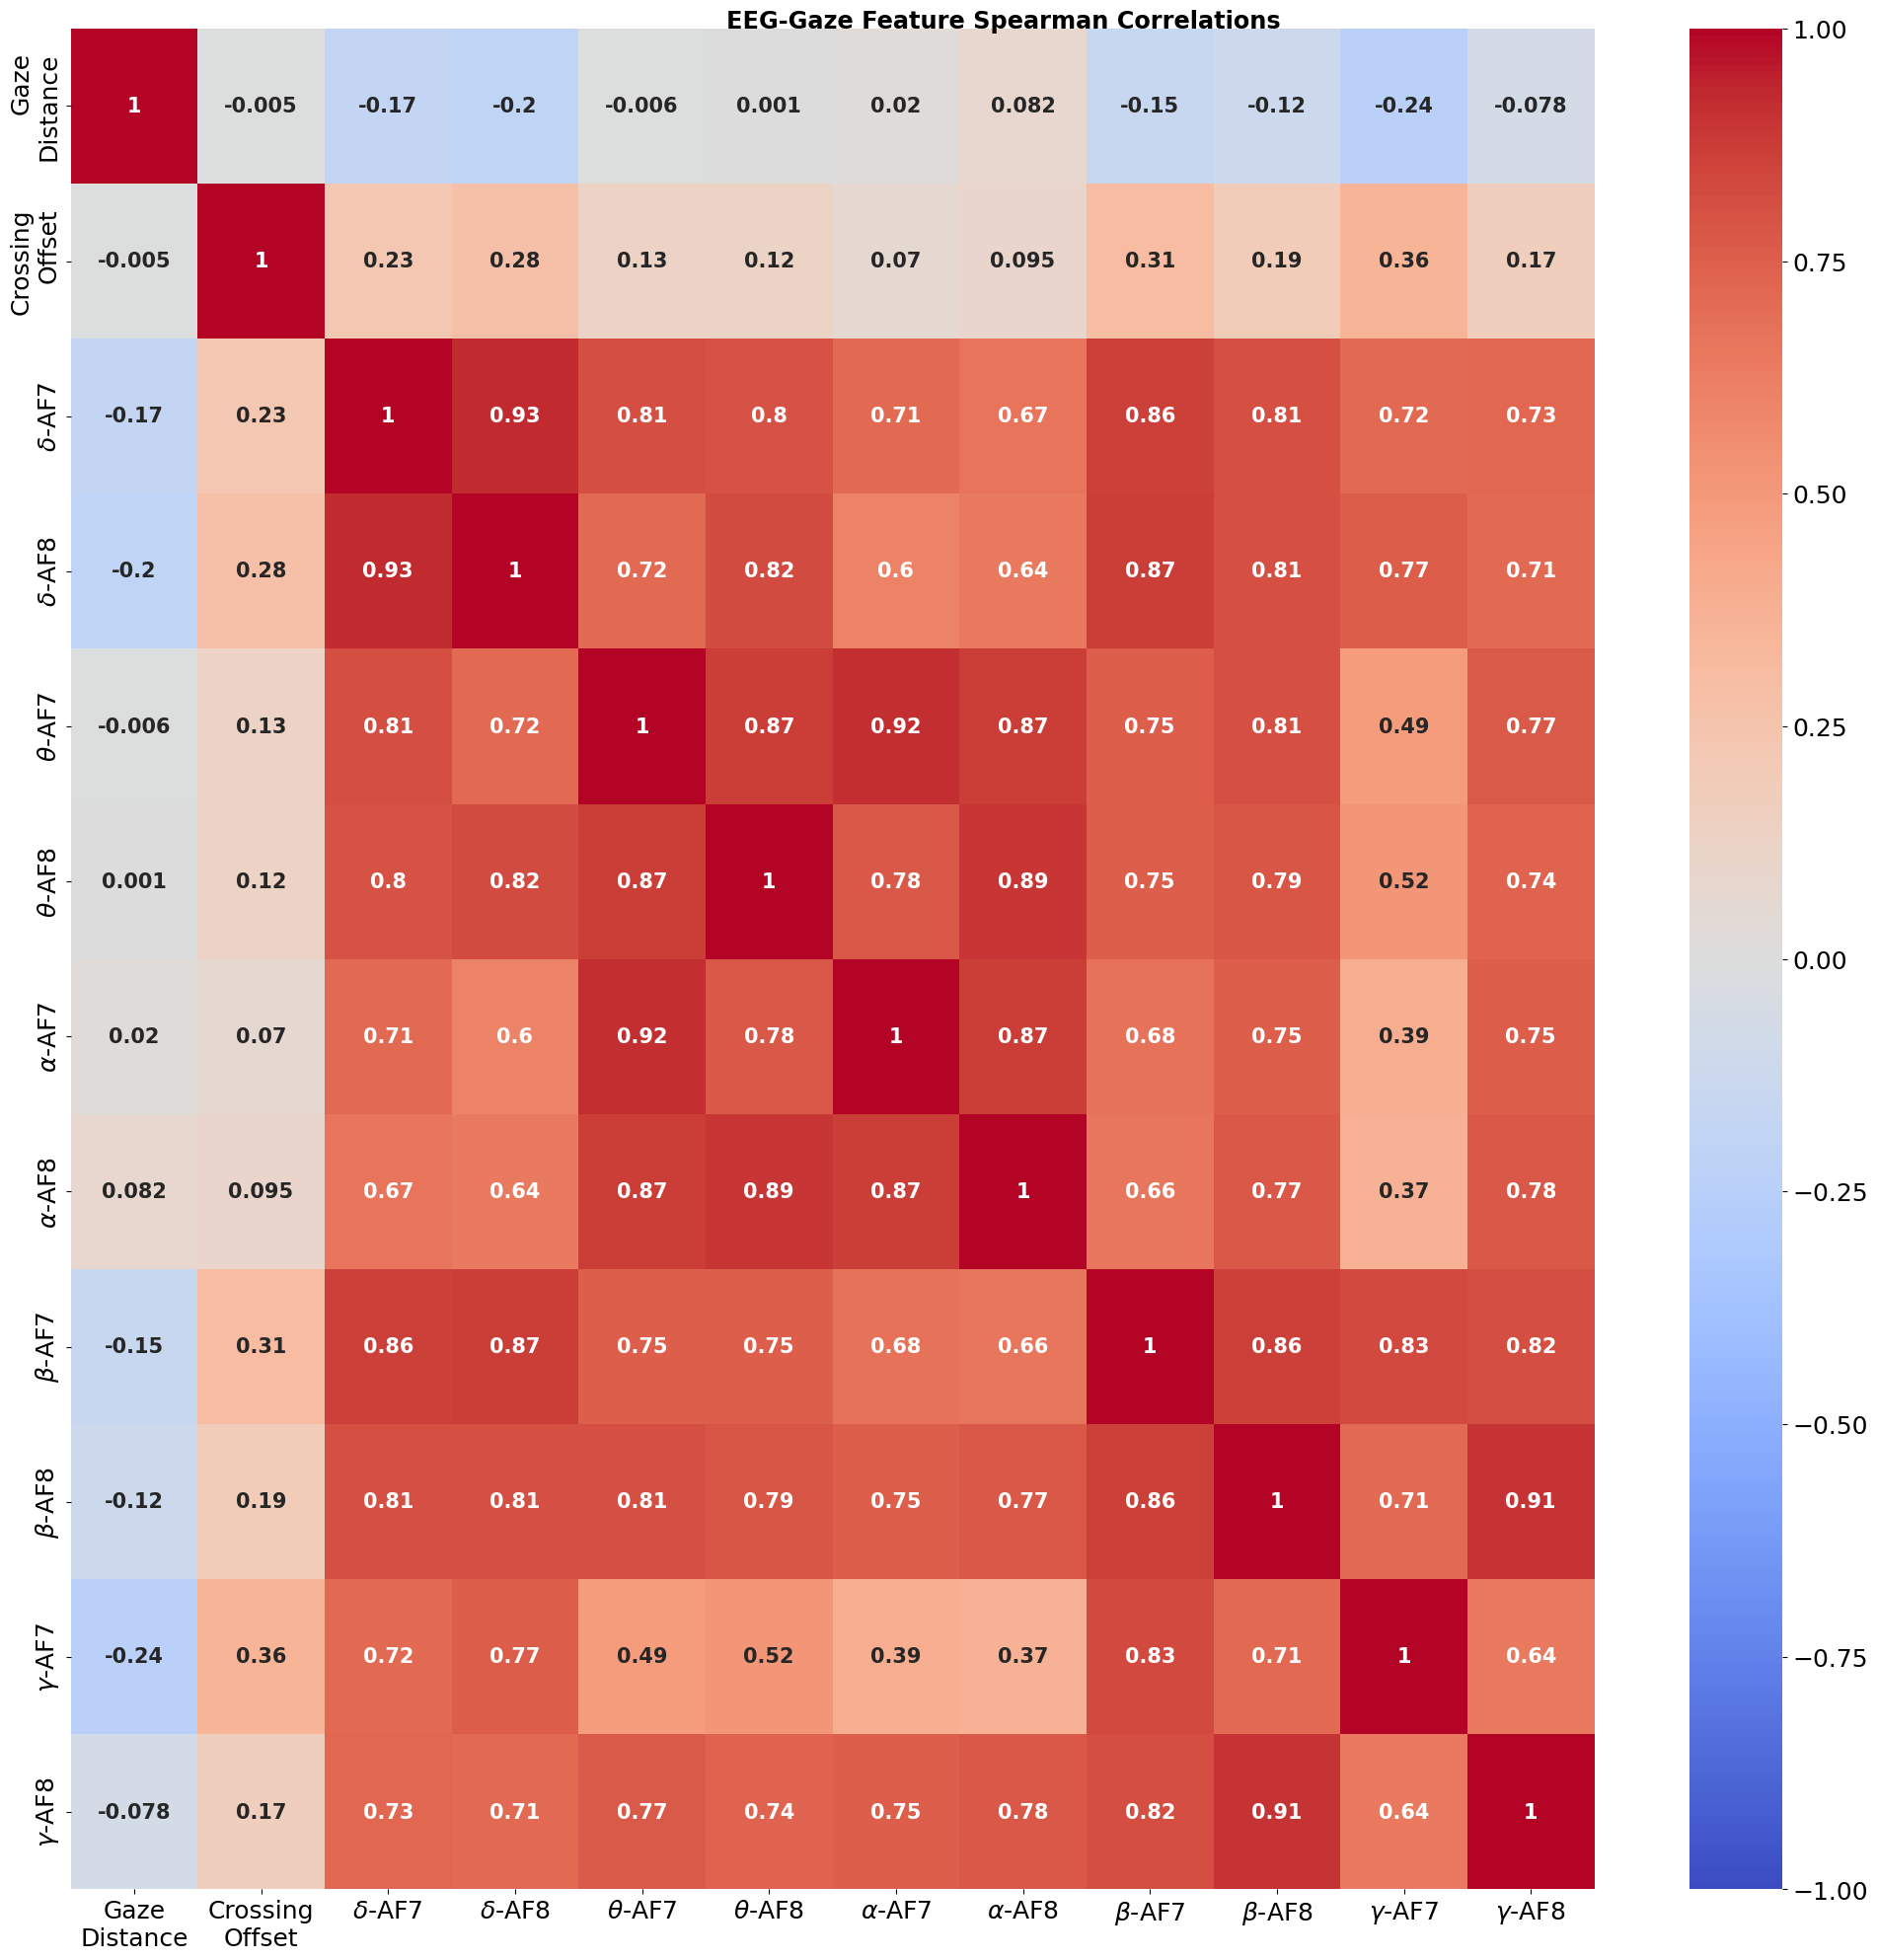

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
fig.suptitle('EEG-Gaze Feature Spearman Correlations', fontsize='xx-large', fontweight='bold')
sns.heatmap(s_plot, 
    ax=ax,
    xticklabels=s_plot.columns.values, 
    yticklabels=s_plot.columns.values, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    annot_kws={'fontsize':15,'fontweight':'bold'}
)
plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.png'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.svg'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.pdf'), format='pdf', bbox_inches='tight', pad_inches=0.1)


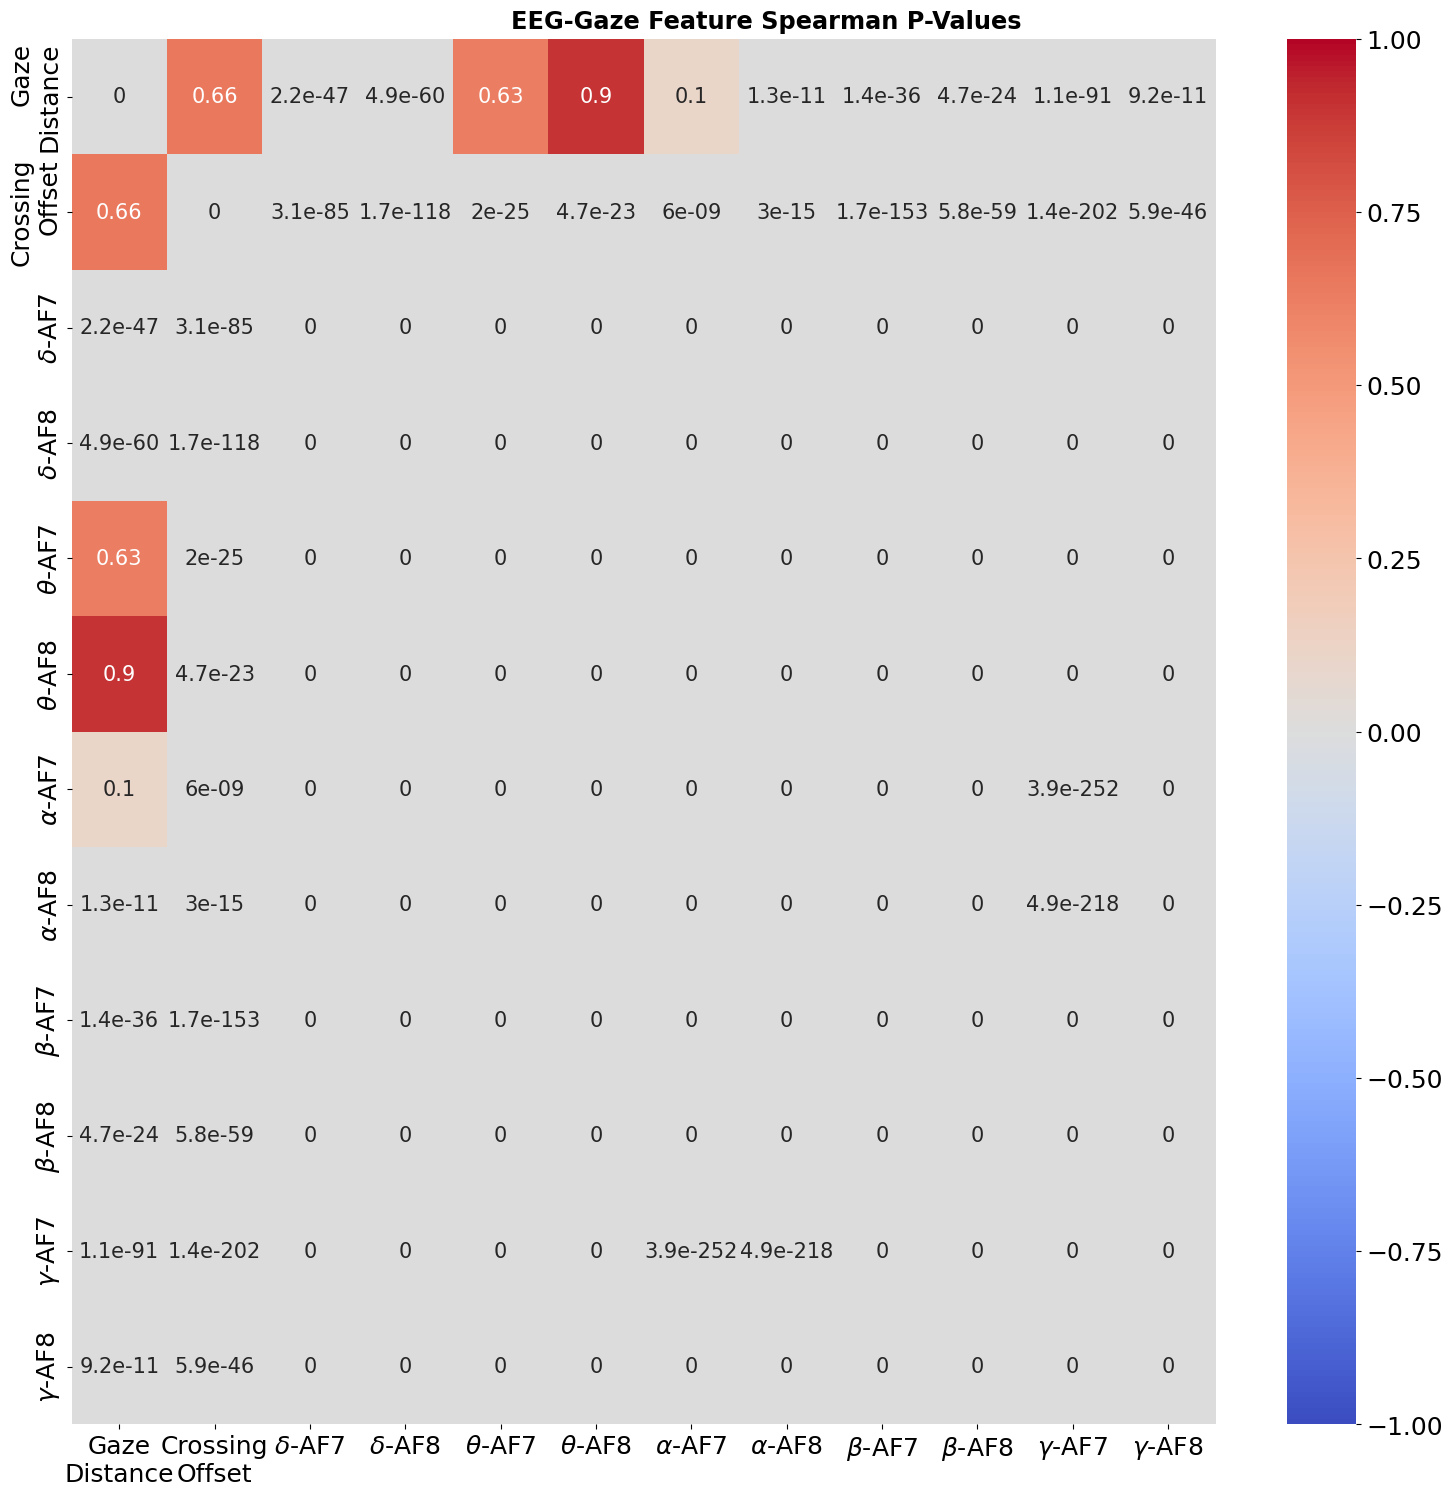

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle('EEG-Gaze Feature Spearman P-Values', fontsize='xx-large', fontweight='bold')
sns.heatmap(p_plot, 
    ax=ax,
    xticklabels=p_plot.columns.values, 
    yticklabels=p_plot.columns.values, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    annot_kws={'fontsize':15}
)
plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_pvalues.png'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_pvalues.svg'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_pvalues.pdf'), format='pdf', bbox_inches='tight', pad_inches=0.1)


### Combining Correlation Strength and P-Values

C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_13052\3702601937.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00
(p=
0)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.iloc[i, j] = f"{s_plot.iloc[i, j]:.2f}\n(p=\n{p_plot.iloc[i, j]:.4g})"
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_13052\3702601937.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01
(p=
0.655)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.iloc[i, j] = f"{s_plot.iloc[i, j]:.2f}\n(p=\n{p_plot.iloc[i, j]:.4g})"
C:\Users\Ryan Kim\AppData\Local\Temp\ipykernel_13052\3702601937.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.17
(p=
2.169e-47)' has dtype inco

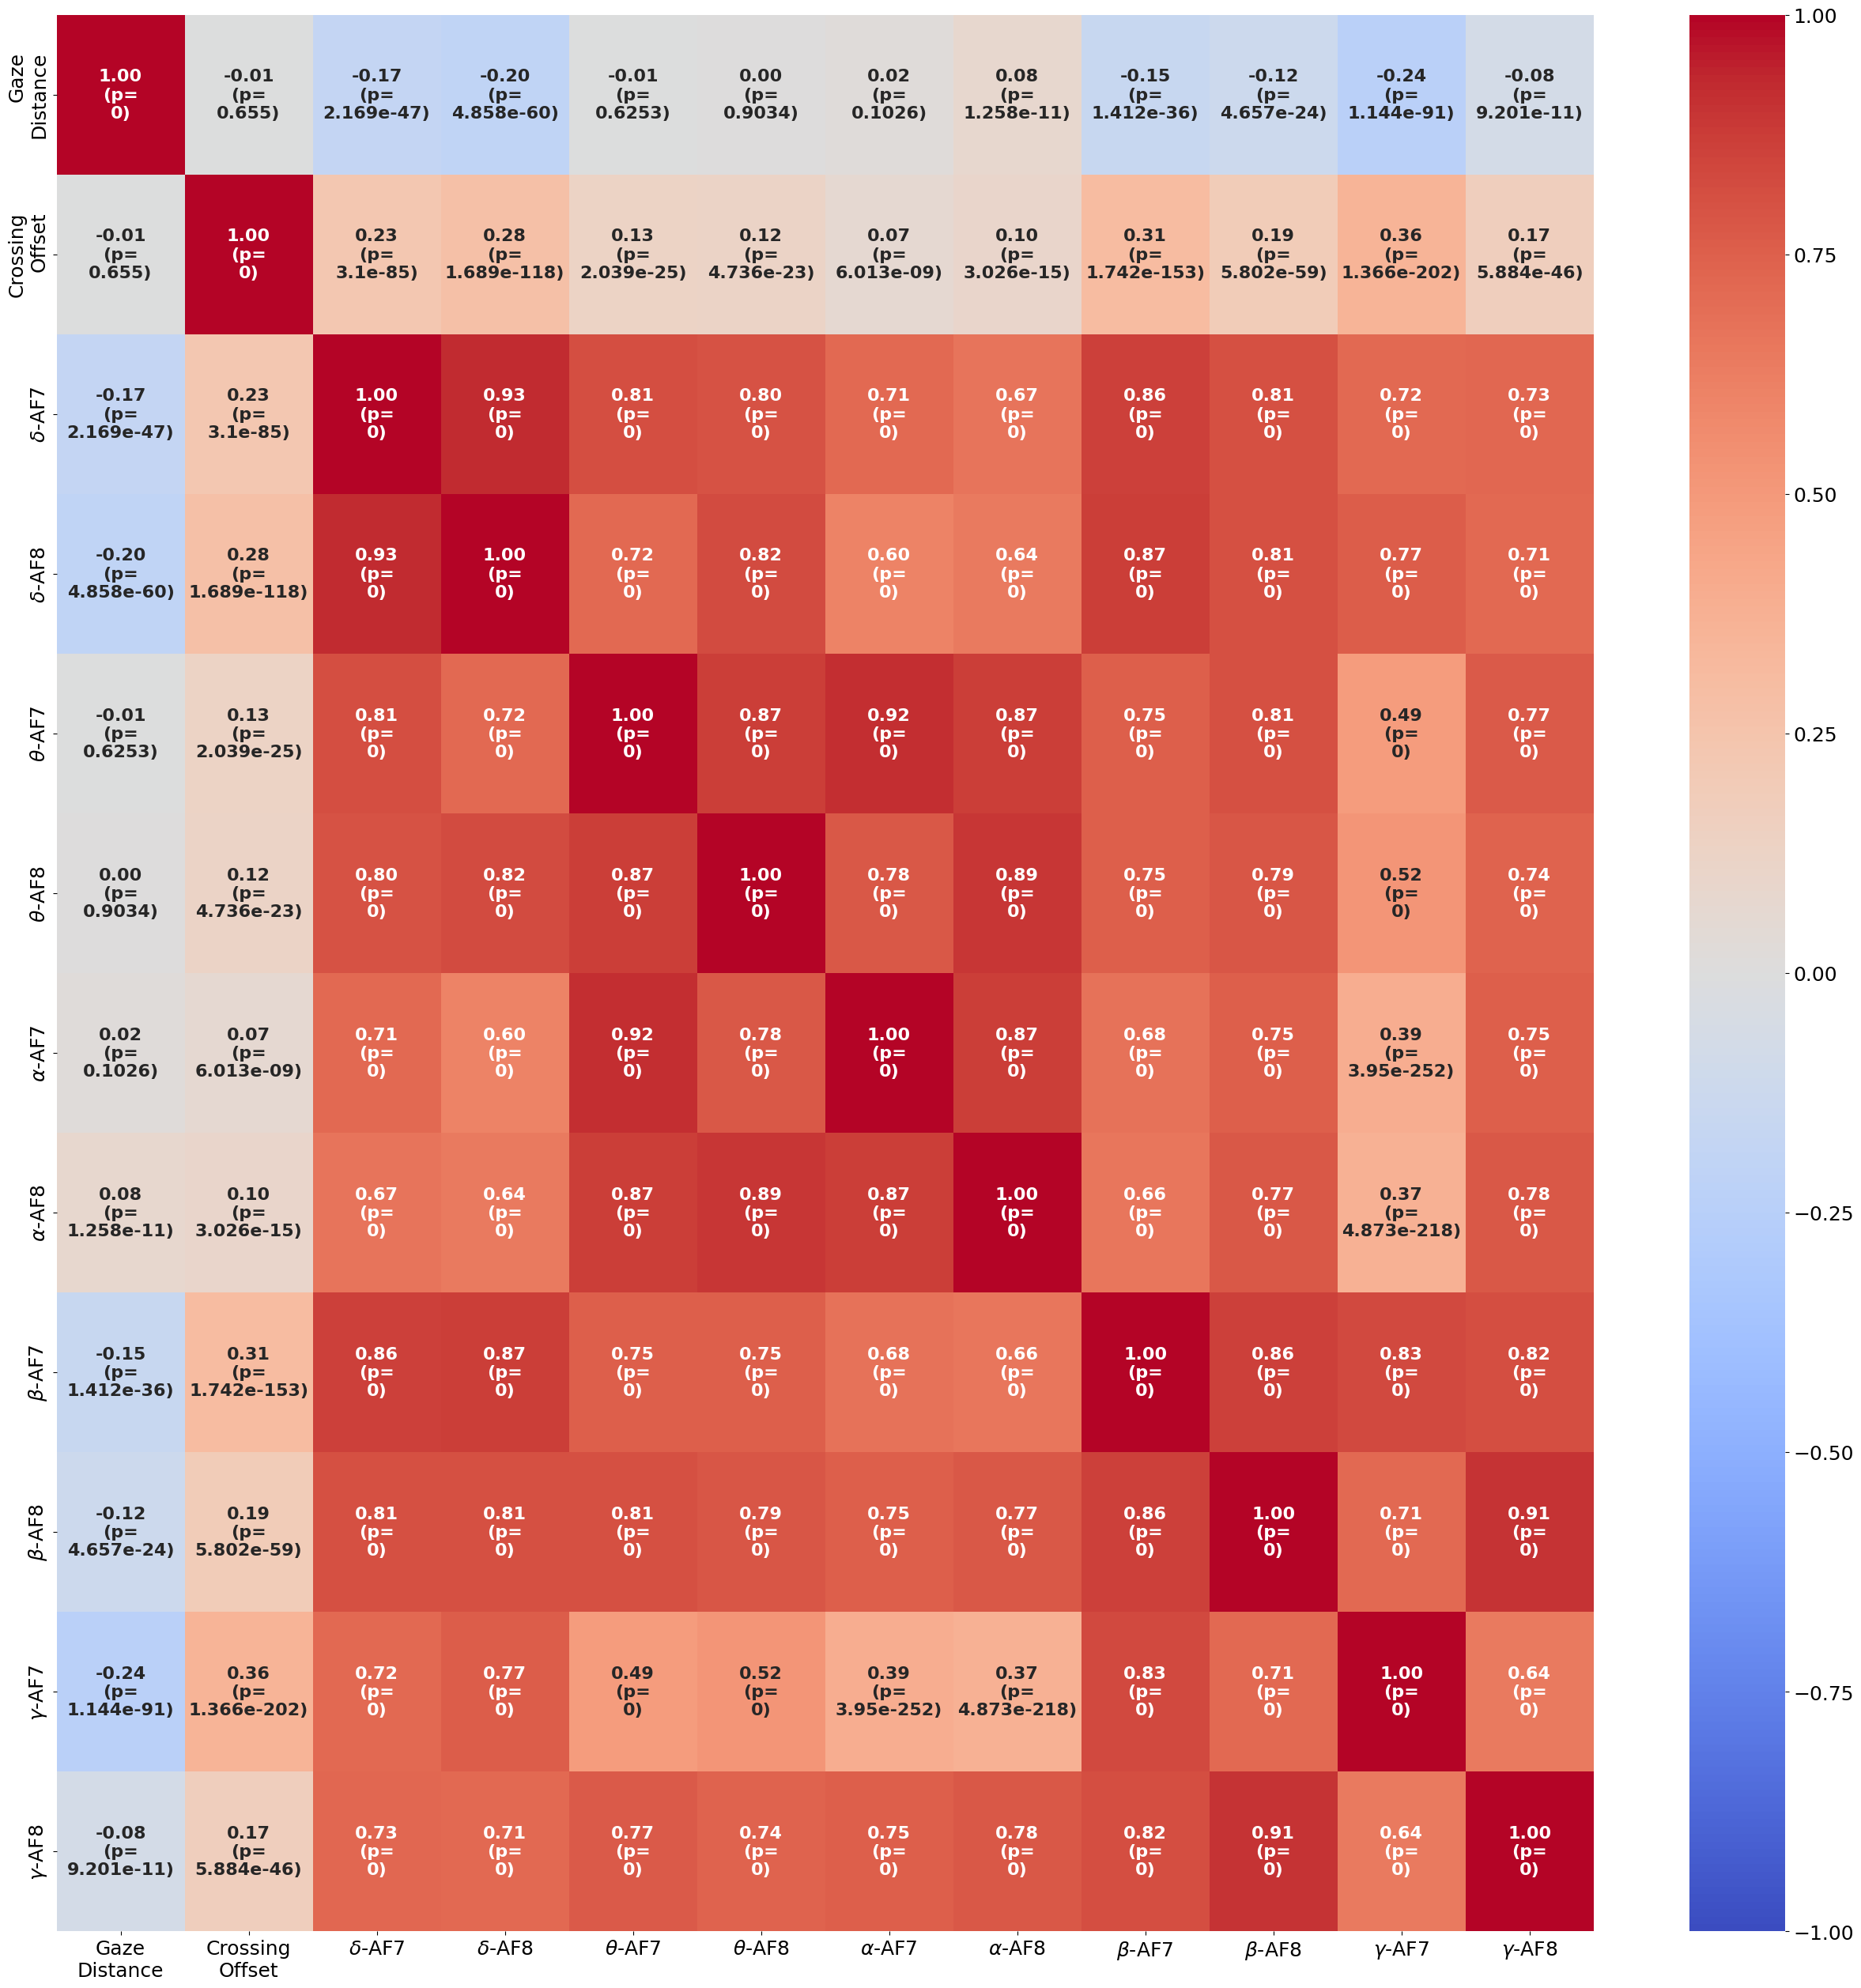

In [25]:
annot = s_plot.copy()
for i in range(s_plot.shape[0]):
    for j in range(s_plot.shape[1]):
        annot.iloc[i, j] = f"{s_plot.iloc[i, j]:.2f}\n(p=\n{p_plot.iloc[i, j]:.4g})"

fig, ax = plt.subplots(figsize=(25,25))
#fig.suptitle('EEG-Gaze Feature Spearman Correlations', fontsize='xx-large', fontweight='bold')
sns.heatmap(s_plot, 
    ax=ax,
    xticklabels=s_plot.columns.values, 
    yticklabels=s_plot.columns.values, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=annot,
    fmt='',
    annot_kws={'fontsize':16,'fontweight':'bold'}
)
plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.png'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.svg'), bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations.pdf'), format='pdf', bbox_inches='tight', pad_inches=0.1)

## 2b. Gaze Behaviors

In [ ]:
# Define custom color for points
points_color = [179, 162, 224]
clr = [x/255 for x in points_color]

# Commons
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(12)
fig.suptitle('Gaze Hits on Vehicles', fontsize='xx-large', fontweight='bold')
fig.supxlabel('Time w.r.t. Crossing Offset (seconds)', fontsize='x-large',fontweight='bold')
fig.supylabel('Gaze Distance from Participant (meters)', fontsize='x-large', fontweight='bold')
ax.xaxis.set_inverted(True)

# Scatter
#ax.title.set_text('Raw Gaze hits')
g0 = sns.scatterplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    color=clr,
    sizes=(50, 200),
    ax=ax
)
g0.set(xlabel=None, ylabel=None)

# KDE Plot
#ax.title.set_text('KDE')
g1 = sns.kdeplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    cmap='viridis', 
    alpha=1.0,
    fill=False, 
    thresh=0, 
    levels=50, 
    ax=ax
)
g1.set(xlabel=None, ylabel=None)

# Save and Show
plt.tight_layout()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(os.path.join(_OUTPUT_DIR,'gaze_frequencies.png'), bbox_inches="tight", pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR,'gaze_frequencies.svg'), bbox_inches="tight", pad_inches=0.1)
plt.savefig(os.path.join(_OUTPUT_DIR,'gaze_frequencies.pdf'), format='pdf', bbox_inches="tight", pad_inches=0.1)
plt.show()


## 2c. Plotting Raw EEG

### Plotting Function

In [ ]:
# Helper function: Plotting frequency bands in a horizontal time-series way
# Note that it plots two separate images. You'll have to manually combine them later in an image editor.
def PlotEEGHorizontal(df, frequencies, electrodes, colors, trial_df=None, suptitle:str=None, save_figname:str=None):
    # Let's display this participant's EEG data
    plt.figure(figsize=(15,5))
    
    for j in range(len(electrodes)):
        electrode = electrodes[j]
        
        fig, axes = plt.subplots(nrows=len(frequencies), ncols=1, sharex=True)
        fig.set_figheight(5)
        fig.set_figwidth(15)
        
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            ax = df.plot.line(x='unix_ms',y=colname, ax=axes[i], color=color)
            ax.legend_ = None         
            
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None);
        plt.subplots_adjust(wspace=0, hspace=0)
        if save_figname: 
            plt.savefig(f'{save_figname}_{electrode}', bbox_inches="tight", pad_inches=0)
        plt.cla()
            

### Figure Generation

In [ ]:
iDisplay(Markdown('## _Example:_'))

dfs = ProcessParticipant(os.path.join(_DATA_DIR, 'P1'), calculate_results=False)
PlotEEGHorizontal(dfs['eeg'], _FREQUENCY_BANDS, _ELECTRODES, _FREQUENCY_COLORS, trial_df=dfs['trial'], suptitle='P1-test', save_figname=f'{_OUTPUT_DIR}P1_eeg_hor-test')


# 3. Additional Figures

In [ ]:
# Create additional figures directory, if not exists
_ADD_OUTPUT_DIR = os.path.join(_DATA_DIR, f'outputs_additional_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/')
try: os.makedirs(_ADD_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

## 3a. Modded Gaze Hits

In [ ]:
# Define custom color for points
points_color = [179, 162, 224]
clr = [x/255 for x in points_color]

# Commons
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(12)
fig.suptitle('Gaze Hits on Vehicles', fontsize='xx-large', fontweight='bold')
fig.supxlabel('Time w.r.t. Crossing Offset (seconds)', fontsize='x-large',fontweight='bold')
fig.supylabel('Gaze Distance from Participant (meters)', fontsize='x-large', fontweight='bold')
ax.xaxis.set_inverted(True)

# Coloration
ax.axvline(x=0, c="black")
ax.axvline(x=10, c="gray", alpha=0.5)
ax.axvline(x=20, c="gray", alpha=0.5)
ax.axvline(x=30, c="gray", alpha=0.5)
ax.axvline(x=40, c="gray", alpha=0.5)
ax.axvline(x=-10, c="gray", alpha=0.5)
ax.axvline(x=-20, c="gray", alpha=0.5)

# Scatter
#ax.title.set_text('Raw Gaze hits')
g0 = sns.scatterplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    color=clr,
    sizes=(50, 200),
    ax=ax
)
g0.set(xlabel=None, ylabel=None)

# KDE Plot
#ax.title.set_text('KDE')
g1 = sns.kdeplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    cmap='viridis', 
    alpha=1.0,
    fill=False, 
    thresh=0, 
    levels=50, 
    ax=ax
)
g1.set(xlabel=None, ylabel=None)

# Save and Show
plt.tight_layout()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(os.path.join(_ADD_OUTPUT_DIR,'gaze_frequencies.png'), bbox_inches="tight", pad_inches=0.1)
plt.savefig(os.path.join(_ADD_OUTPUT_DIR,'gaze_frequencies.svg'), bbox_inches="tight", pad_inches=0.1)
plt.savefig(os.path.join(_ADD_OUTPUT_DIR,'gaze_frequencies.pdf'), format='pdf', bbox_inches="tight", pad_inches=0.1)
plt.show()

## 3b. Trial-Aligned Figures

In [ ]:
def Generate_Blank_TrialDuration(trials_df, crossings_df, trial_ids, row_height=2, row_width_ratio=1, save_figname=None):
    # Goal: Generate a horizontal time-aligned chart that 
    # discretizes prior and after crossing onset.
    # Height is set as a static float. Width is a ratio dependent on trial length
    
    # Isolate only to the relevant trials
    trials = trials_df[trials_df['trial_number'].isin(trial_ids)]
    crossings = crossings_df[crossings_df['group'].isin(trial_ids)]
    crossings.reset_index(drop=True, inplace=True)
    combined = pd.merge(trials, crossings, how='left', left_on="trial_number", right_on="group")
    combined.drop(columns=[
        'car_congestion',
        'start_frame_x',
        'start_unix',
        'start_unix_ms',
        'end_frame_x',
        'end_unix',
        'end_unix_ms',
        'start_frame_y',
        'end_frame_y',
        'group'], inplace=True)
    combined.rename(columns={
        'start_timestamp':'trial_start',
        'end_timestamp':'trial_end',
        'start_rel_sec':'crossing_start',
        'end_rel_sec':'crossing_end'
    }, inplace=True)
    combined['crossing_duration'] = combined['crossing_end']-combined['crossing_start']
    
    # using combined, calculate relative start and end frames
    ref = combined['crossing_start']
    combined['rel_trial_start'] = combined['trial_start'] - ref
    combined['rel_trial_end'] = combined['trial_end'] - ref
    combined['rel_crossing_start'] = combined['crossing_start'] - ref
    combined['rel_crossing_end'] = combined['crossing_end'] - ref
    combined.drop(columns=[
        'trial_start',
        'trial_end',
        'crossing_start',
        'crossing_end'], inplace=True)
    combined.rename(columns={
        'rel_trial_start':'trial_start',
        'rel_trial_end':'trial_end',
        'rel_crossing_start':'crossing_start',
        'rel_crossing_end':'crossing_end'
    }, inplace=True)
    combined['crossing_end'] = np.minimum(combined['crossing_end'], combined['trial_end'])    
    display(combined)
    
    # Calculate figure height and width based on trial length
    num_rows = len(combined.index)
    height = row_height * num_rows
    width = trials['trial_duration'].max() * row_width_ratio
    print("HEIGHT:", height, "WIDTH:", width)

    # Start Plotting
    plt.figure(figsize=(width,height))
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, sharex=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(num_rows):
        # We aren't plotting anything.
        # We're just generating colors and lines
        ax = axes[i]
        trial = combined.iloc[i].to_dict()
        # For this trial, how many axvlines do we want on eithe side?
        min_vline_x = math.ceil(trial['trial_start']/10)
        max_vline_x = math.floor(trial['trial_end']/10)
        # Start printing stuff
        ax.axvline(x=0, c='black')
        for j1 in range(min_vline_x, 0):
            ax.axvline(x=j1*10, c="gray", alpha=0.5)
        if max_vline_x > 10:
            for j2 in range(10, max_vline_x):
                ax.axvline(x=j2*10, c="gray", alpha=0.5)
        #ax.axvline(x=-30, c="gray", alpha=0.5)
        #ax.axvline(x=-40, c="gray", alpha=0.5)
        #ax.axvline(x=10, c="gray", alpha=0.5)
        #ax.axvline(x=20, c="gray", alpha=0.5)
        ax.axvspan(trial['trial_start'], 0, color='red',alpha=0.3)
        ax.axvspan(0, trial['crossing_end'], color='blue',alpha=0.3)
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None, ylabel=None)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save figure
    if save_figname is not None: 
        plt.savefig(save_figname, bbox_inches="tight", pad_inches=0)
    plt.show()


In [ ]:
for pdir in _PARTICIPANTS:
    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
    dfs_trials = dfs['trial']
    dfs_trials['trial_duration'] = dfs_trials['end_timestamp'] - dfs_trials['start_timestamp']
    trials_df = dfs_trials[dfs_trials['trial_number']!=0]
    dfs_crossings = dfs['crossings']
    crossings_df = dfs_crossings[dfs_crossings['group']!=0]
    Generate_Blank_TrialDuration(
        trials_df, 
        crossings_df, 
        [1,2,3,4,5,6],
        save_figname=os.path.join(_ADD_OUTPUT_DIR,f'{pdir}_trial_duration.png')
    )

## 3c. Participant-Specific Gaze Frequencies

In [ ]:
# Define custom color for points
points_color = [179, 162, 224]
clr = [x/255 for x in points_color]

for pdir in _PARTICIPANTS_DIRS_GAZES:
    # Commons
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle(f'{pdir}): Gaze Hits on Vehicles', fontsize='xx-large', fontweight='bold')
    fig.supxlabel('Time w.r.t. Crossing Offset (seconds)', fontsize='x-large',fontweight='bold')
    fig.supylabel('Gaze Distance from Participant (meters)', fontsize='x-large', fontweight='bold')
    ax.xaxis.set_inverted(True)

    # Coloration
    ax.axvline(x=0, c="black")
    ax.axvline(x=10, c="gray", alpha=0.5)
    ax.axvline(x=20, c="gray", alpha=0.5)
    ax.axvline(x=30, c="gray", alpha=0.5)
    ax.axvline(x=40, c="gray", alpha=0.5)
    ax.axvline(x=-10, c="gray", alpha=0.5)
    ax.axvline(x=-20, c="gray", alpha=0.5)

    # Scatter
    #ax.title.set_text('Raw Gaze hits')
    g0 = sns.scatterplot(
        x='crossing_offset_unix_sec', 
        y='screen_pos_z', 
        data=global_evc_df[global_evc_df['participant']==pdir], 
        color=clr,
        sizes=(50, 200),
        ax=ax
    )
    g0.set(xlabel=None, ylabel=None)

    # KDE Plot
    #ax.title.set_text('KDE')
    g1 = sns.kdeplot(
        x='crossing_offset_unix_sec', 
        y='screen_pos_z', 
        data=global_evc_df[global_evc_df['participant']==pdir], 
        cmap='viridis', 
        alpha=1.0,
        fill=False, 
        thresh=0, 
        levels=50, 
        ax=ax
    )
    g1.set(xlabel=None, ylabel=None)

    # Save and Show
    plt.tight_layout()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(os.path.join(_ADD_OUTPUT_DIR,f'{pdir}_gaze_frequencies.png'), bbox_inches="tight", pad_inches=0.1)
    plt.show()

## 3d. Combining Gaze and EEG Per Trial

In [ ]:
def GetTrialDurations(raw_dfs, trial_ids):
    # Basics
    dfs_trials = raw_dfs['trial']
    dfs_trials['trial_duration'] = dfs_trials['end_timestamp'] - dfs_trials['start_timestamp']
    trials_df = dfs_trials[dfs_trials['trial_number']!=0]
    dfs_crossings = raw_dfs['crossings']
    crossings_df = dfs_crossings[dfs_crossings['group']!=0]
    
    # Combine
    trials = trials_df[trials_df['trial_number'].isin(trial_ids)]
    crossings = crossings_df[crossings_df['group'].isin(trial_ids)]
    crossings.reset_index(drop=True, inplace=True)
    combined = pd.merge(trials, crossings, how='left', left_on="trial_number", right_on="group")
    combined.drop(columns=[
        'car_congestion',
        'group'], inplace=True)
    combined.rename(columns={
        'start_timestamp':'trial_start',
        'end_timestamp':'trial_end',
        'start_frame_x':'trial_start_frame',
        'end_frame_x':'trial_end_frame',
        'start_frame_y':'crossing_start_frame',
        'end_frame_y':'crossing_end_frame',
        'start_unix_ms':'trial_start_unix_ms',
        'end_unix_ms':'trial_end_unix_ms',
        'start_unix':'crossing_start_rel_unix_ms',
        'end_unix':'crossing_end_rel_unix_ms'
    }, inplace=True)
    return combined

In [ ]:
#display(global_evc_df[
#    (global_evc_df['participant']=='P1') & 
#    (global_evc_df['trial_number']==2)])

dfs = ProcessParticipant(os.path.join(_DATA_DIR, 'P1'), calculate_results=False)

display(dfs['eeg'])
display(dfs['trial'])

durations = GetTrialDurations(dfs, [1,2,3,4,5,6])
display(durations[durations['trial_number']==1])

test_eeg = dfs['eeg']['unix_ms']
display(test_eeg)

In [ ]:
for pdir in _PARTICIPANTS:
    # Create output folder, if not exists
    _ADD_OUTPUT_DIR2 = os.path.join(_ADD_OUTPUT_DIR, f'{pdir}/')
    if not os.path.exists(_ADD_OUTPUT_DIR2): os.makedirs(_ADD_OUTPUT_DIR2)
    
    evc = global_evc_df[global_evc_df['participant']==pdir]
    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
    durations = GetTrialDurations(dfs, [1,2,3,4,5,6])
    eeg = dfs['eeg']
    
    for i in range(6):
        # should contain both eeg and gaze data for this trial
        trial_evc = evc[evc['trial_number']==i+1]
        
        trial_duration = durations.iloc[i].to_dict()
        start_frame = trial_duration['trial_start_frame']
        end_frame = trial_duration['crossing_end_frame']
        frame_duration = end_frame - start_frame
        
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.set_figheight(8)
        fig.set_figwidth(12)
        fig.suptitle(f'{pdir}) - Trial {i+1}: Gaze Hits on Vehicles', fontsize='xx-large', fontweight='bold')
        #fig.supxlabel('Time w.r.t. Crossing Offset (seconds)', fontsize='x-large',fontweight='bold')
        #fig.supylabel('Gaze Distance from Participant (meters)', fontsize='x-large', fontweight='bold')
        plt.setp(plt.gcf().get_axes(), xlabel=None, ylabel=None);
        ax.set_ylim([30, 52.5])
        ax.xaxis.set_inverted(True)
        
        # Coloration
        points_color = [179, 162, 224]
        clr = [x/255 for x in points_color]

        # Scatter
        g0 = sns.scatterplot(
            x='crossing_offset_unix_sec', 
            y='screen_pos_z', 
            data=trial_evc, 
            color='blue',
            sizes=(50, 200),
            ax=ax
        )
        g0.set(xlabel=None, ylabel=None)
        axxlim = ax.get_xlim()
        ax.axvspan(axxlim[0], 0, color='red', alpha=0.05, zorder=0)
        if (axxlim[1] < 0): ax.axvspan(axxlim[1], 0, color='blue', alpha=0.05, zorder=0)
        min_vline_x = math.floor(axxlim[0]/5)+1
        max_vline_x = math.ceil(-axxlim[1]/5)-1
        print(min_vline_x, max_vline_x)
        for j1 in range(0, min_vline_x):
            ax.axvline(x=j1*5, c="gray", alpha=0.5)
        ax.axvline(x=0, c="black")
        plt.tight_layout()
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(os.path.join(_ADD_OUTPUT_DIR2,f'{pdir}_trial-{i+1}_gaze_frequencies.png'), bbox_inches="tight", pad_inches=0.1)
        plt.show()
        plt.cla()
        

In [ ]:
def PlotEEGHorizontal2(df, frequencies, electrodes, colors, trial_df=None, suptitle:str=None, save_figname:str=None):
    # Let's display this participant's EEG data
    fig, axes = plt.subplots(nrows=4,ncols=1, sharex=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
    for j in range(len(electrodes)):
        electrode = electrodes[j]
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            ax = df.plot.scatter(x='unix_ms',y=colname, ax=axes[i], color=color)
            ax.legend_ = None
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            ax = df.plot.line(x='unix_ms',y=colname, ax=axes[i], color=color, alpha=0.25)
            ax.legend_ = None    
    
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None, ylabel=None);
    plt.subplots_adjust(wspace=0, hspace=0)
    if save_figname: 
        plt.savefig(f'{save_figname}_{electrode}', bbox_inches="tight", pad_inches=0)
    plt.cla()
        
for pdir in _PARTICIPANTS:
    # Create output folder, if not exists
    _ADD_OUTPUT_DIR2 = os.path.join(_ADD_OUTPUT_DIR, f'{pdir}/')
    if not os.path.exists(_ADD_OUTPUT_DIR2): os.makedirs(_ADD_OUTPUT_DIR2)
    
    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
    eeg = dfs['eeg']
    trial_timings = dfs['trial']
    
    for i in [1,2,3,4,5,6]:
        # should contain both eeg and gaze data for this trial
        trial_duration = trial_timings[trial_timings['trial_number']==i].iloc[0].to_dict()
        print(trial_duration)
        trial_eeg = eeg[(eeg['unix_ms'] >= trial_duration['start_unix']) & (eeg['unix_ms'] < trial_duration['end_unix'])]
        display(trial_eeg)
        save_filename = os.path.join(_ADD_OUTPUT_DIR2, f'{pdir}_trial-{i}_eeg')
        print(save_filename)
        PlotEEGHorizontal2(
            trial_eeg, 
            _FREQUENCY_BANDS, 
            _ELECTRODES, 
            _FREQUENCY_COLORS, 
            save_figname=save_filename
        )

# 4. Misc. Testing

## 4a. KDE Coloration with Scatter Plots

In [ ]:
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Prepare data
df = global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)]
x = df['crossing_offset_unix_sec'].values
y = df['screen_pos_z'].values

# Calculate KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)  # Evaluate KDE at each data point

# Normalize KDE values to colormap range
norm = Normalize(vmin=min(kde), vmax=max(kde))
colors = plt.cm.viridis(norm(kde))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('KDE-based Densities of Gaze Hits on Vehicles')
fig.supxlabel('Time w.r.t. Crossing Offset (sec)')
fig.supylabel('Gaze Distance from Participant')
ax.xaxis.set_inverted(True)

scatter = ax.scatter(x, y, c=colors, alpha=0.25, s=50)

# Optional: add colorbar for reference
sm = ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
#fig.colorbar(sm, ax=ax, label='KDE-based Density')
fig.colorbar(sm, ax=ax)

# Save and show
plt.tight_layout()
plt.show()

## 4b. Color Testing with KDE-Scatter Overlaps

In [ ]:
import math 
# Define custom color for points
points_colors = [
    [179, 162, 224],
    [206, 190, 250],
    [167, 159, 191],
    [148, 112, 255],
    [100, 81, 156]
]
nrows = math.ceil(len(points_colors)/3)
ncols = math.ceil(len(points_colors)%3)+1


fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

# Commons
fig.set_figheight(nrows*7.5)
fig.set_figwidth(ncols*7.5)
fig.suptitle('Gaze Hits on Vehicles')
fig.supxlabel('Time w.r.t. Crossing Offset (sec)')
fig.supylabel('Gaze Distance from Participant')

for ci in range(len(points_colors)):
    r = math.floor(ci/3)
    c = math.floor(ci%3)
    clr = [x/255 for x in points_colors[ci]]

        # Scatter
    #axes[0].title.set_text('Raw Gaze hits')
    g0 = sns.scatterplot(
        x='crossing_offset_unix_sec', 
        y='screen_pos_z', 
        data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
        color=clr,
        sizes=(50, 200),
        ax=axes[r,c]
    )
    #g0.set(title='Raw Gaze Hits', xlabel=None, ylabel=None)

    # KDE Plot
    #axes[1].title.set_text('KDE')
    g1 = sns.kdeplot(
        x='crossing_offset_unix_sec', 
        y='screen_pos_z', 
        data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
        cmap='viridis', 
        alpha=1.0,
        fill=False, 
        thresh=0, 
        levels=50, 
        ax=axes[r,c]
    )
    #g1.set(title='KDE', xlabel=None, ylabel=None)
    
    axes[r,c].set_title(points_colors[ci])
    axes[r,c].xaxis.set_inverted(True)

# Show
plt.tight_layout()
plt.show()

## 4c. Separated KDE and Scatter Plots

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

# Commons
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle('Gaze Hits on Vehicles')
fig.supxlabel('Time w.r.t. Crossing Offset (sec)')
fig.supylabel('Distance from Participant')

# Scatter
#axes[0].title.set_text('Raw Gaze hits')
g0 = sns.scatterplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    color='b',
    alpha=0.1,
    sizes=(50, 200),
    ax=axes[0]
)
g0.set(title='Raw Gaze Hits', xlabel=None, ylabel=None)
axes[0].xaxis.set_inverted(True)

# KDE Plot
#axes[1].title.set_text('KDE')
g1 = sns.kdeplot(
    x='crossing_offset_unix_sec', 
    y='screen_pos_z', 
    data=global_evc_df[global_evc_df['participant'].isin(_PARTICIPANTS_DIRS_GAZES)], 
    cmap='viridis', 
    fill=False, 
    thresh=0, 
    levels=50, 
    ax=axes[1]
)
g1.set(title='KDE', xlabel=None, ylabel=None)
axes[1].xaxis.set_inverted(True)

# Show
plt.tight_layout()
plt.show()